In [1]:
from pathlib import Path


DATA_DIR = Path.cwd()  # is recursive, subdirectories are also searched for correct .csv files automatically


def get_csv(filename_snippet: str) -> Path:
    files = list(DATA_DIR.rglob(f'{filename_snippet}*.csv'))
    if files:
        return files[0]
    else:
        raise FileNotFoundError(f'No .csv file found containing "{filename_snippet}"')

# City spending on education

**Base URL for proper table layout:**

https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A7760

**URLs for each year:**

2024 = 45067NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45067NED/table?dl=A783F

2023 = 45063NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45063NED/table?dl=A783F

2022 = 45059NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45059NED/table?dl=A783F

2021 = 45054NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45054NED/table?dl=A783F

2020 = 45050NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45050NED/table?dl=A783F

2019 = 45046NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45046NED/table?dl=A783F

2018 = 45042NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45042NED/table?dl=A783F

2017 = 45038NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45038NED/table?dl=A783F

**=== everything below has different schema, not used! ===**

2016 = 45031NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45031NED/table?dl=A783F

2015 = 45006NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45006NED/table?dl=A783F

2014 = 45005NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45005NED/table?dl=A783F

2013 = 45004NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45004NED/table?dl=A783F

2012 = 45001NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45001NED/table?dl=A783F

2011 = 45008NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45008NED/table?dl=A783F

2010 = 45007NED = https://iv3statline.cbs.nl/#/IV3/nl/dataset/45007NED/table?dl=A783F

In [2]:
from expenditure import get_expenses_df


get_expenses_df(DATA_DIR, only_begroting=True, only_total=True)

Total
Year Gemeenten                
2017 's-Hertogenbosch  34991.0
     Aalsmeer           2971.0
     Alkmaar           16321.0
     Alphen-Chaam        575.0
     Amersfoort        25922.0
...                        ...
2024 Wormerland         1492.0
     Woudenberg         1271.0
     Zaanstad          35525.0
     Zandvoort          2332.0
     Zeist              7955.0

[751 rows x 1 columns]

<Axes: xlabel='Year', ylabel='x1000 €'>

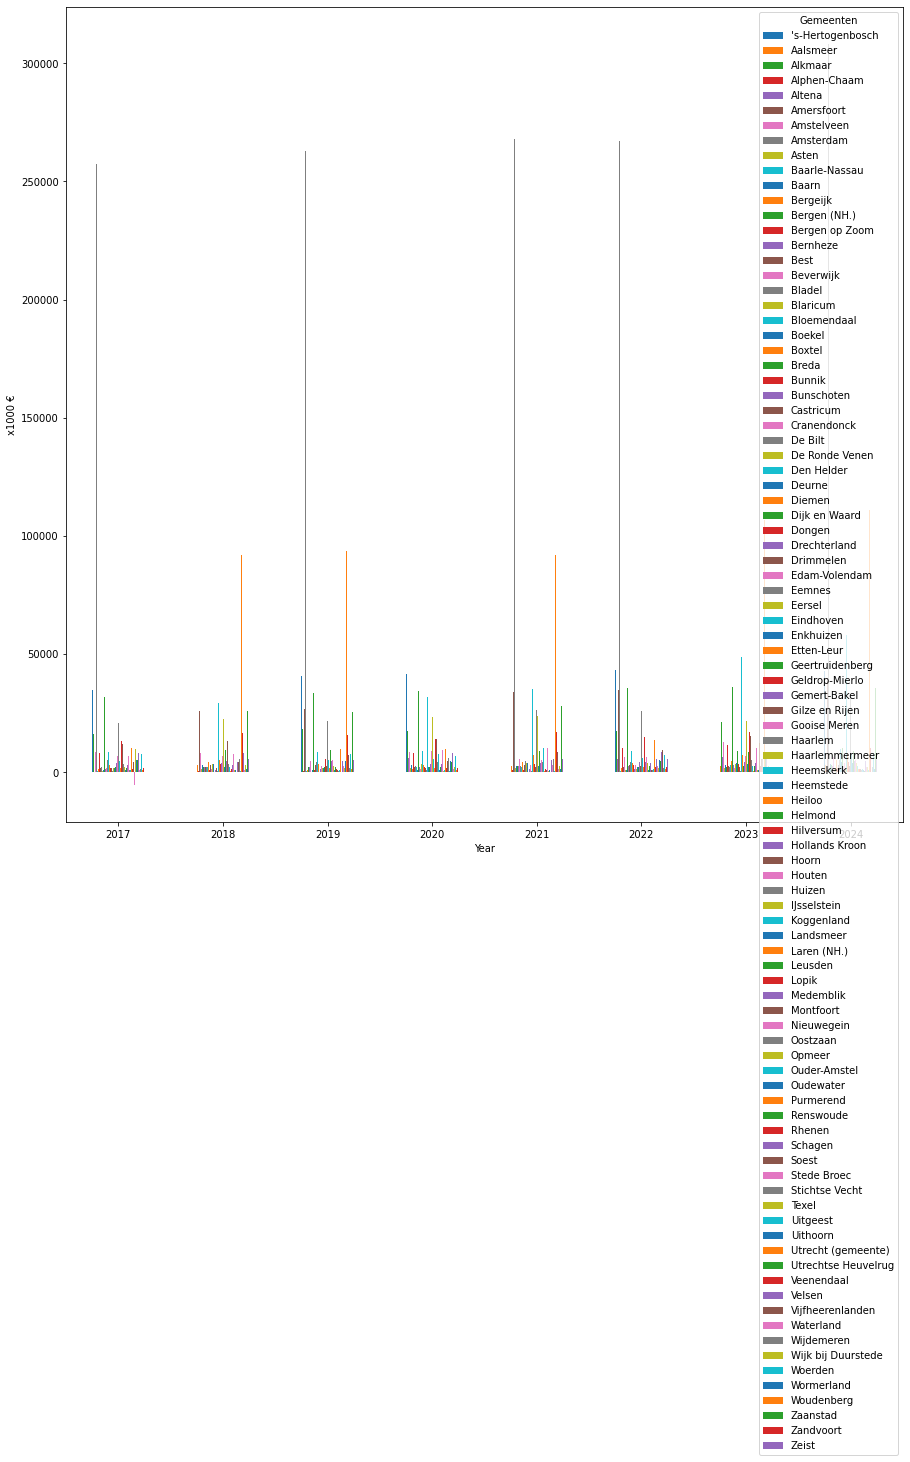

In [3]:
from expenditure import get_expenses_df, plot_expenses


ONLY_SHOW_PRED_EXPENSES = True  # useful since we don't have actual expenses data for 2023 & 2024

plot_expenses(get_expenses_df(DATA_DIR), only_show_begroting=ONLY_SHOW_PRED_EXPENSES)

# Enrollment rates

https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=A7762

In [4]:
from enrollment import get_enrollment_df


get_enrollment_df(get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'))

Total  Primary  Secondary  MBO1  MBO Total  MBO2    HBO  \
Year Gemeenten                                                               
2000 's-Graveland  196.0      NaN        NaN   NaN        NaN   NaN  128.0   
     Aalburg       161.0      NaN        NaN   NaN        NaN   NaN  125.0   
     Aalsmeer      369.0      NaN        NaN   NaN        NaN   NaN  236.0   
     Aarle-Rixtel    NaN      NaN        NaN   NaN        NaN   NaN    NaN   
     Abcoude       206.0      NaN        NaN   NaN        NaN   NaN  123.0   
...                  ...      ...        ...   ...        ...   ...    ...   
2024 Zaanstad        NaN      NaN        NaN   NaN        NaN   NaN    NaN   
     Zandvoort       NaN      NaN        NaN   NaN        NaN   NaN    NaN   
     Zeevang         NaN      NaN        NaN   NaN        NaN   NaN    NaN   
     Zeist           NaN      NaN        NaN   NaN        NaN   NaN    NaN   
     Zijpe           NaN      NaN        NaN   NaN        NaN   NaN    NaN   

                      WO  
Year Gemeenten            
2000 's-Graveland   68.0  
     Aalburg        36.0  
     Aalsmeer      133.0  
     Aarle-Rixtel    NaN  
     Abcoude        83.0  
...                  ...  
2024 Zaanstad        NaN  
     Zandvoort       NaN  
     Zeevang         NaN  
     Zeist           NaN  
     Zijpe           NaN  

[7466 rows x 8 columns]

<Axes: title={'center': 'Total enrollment'}, xlabel='Year', ylabel='Students'>

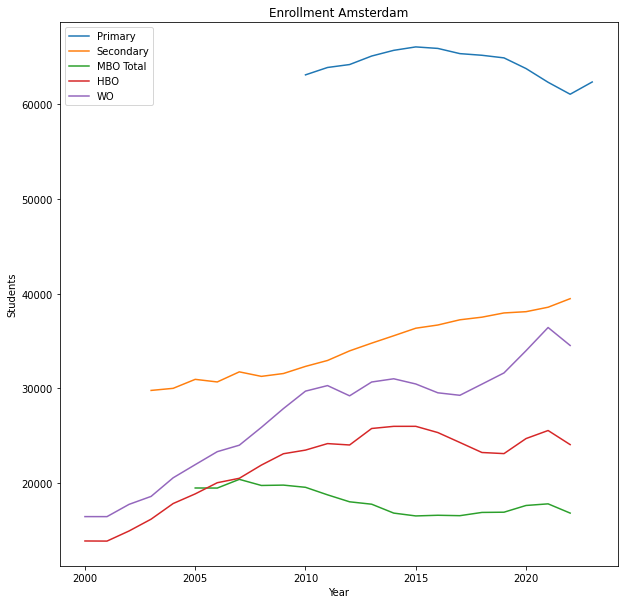

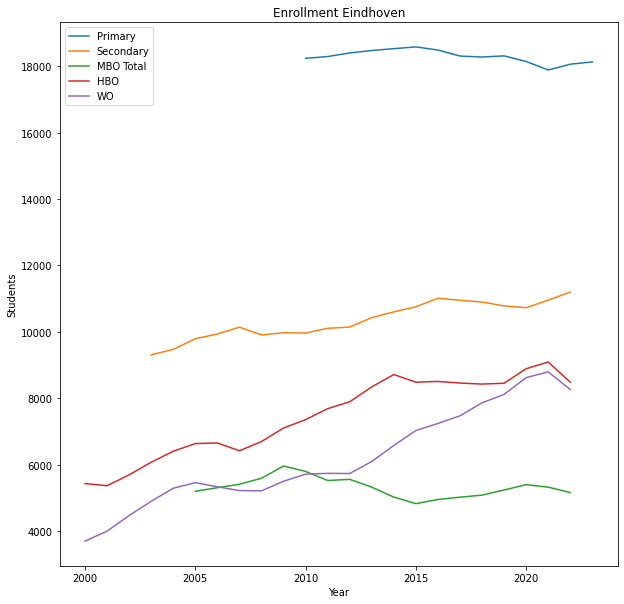

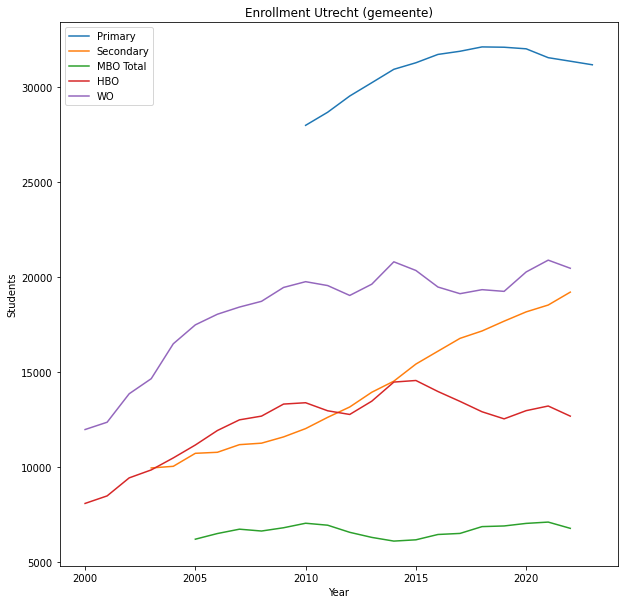

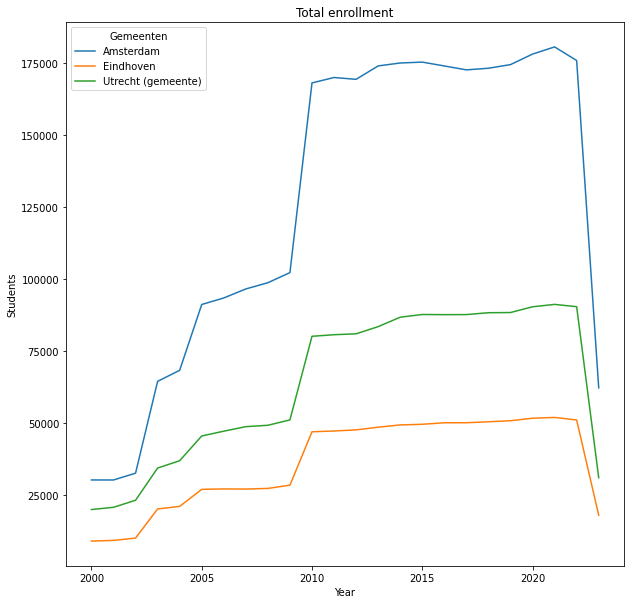

In [5]:
from enrollment import get_enrollment_df, plot_enrollment_city, plot_enrollment_total


df = get_enrollment_df(get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'))

for plot in plot_enrollment_city(df, ['Utrecht (gemeente)', 'Eindhoven', 'Amsterdam'], kind='line'):
    pass  # so long as the plot is 'accessed', the notebook will display it

plot_enrollment_total(df, ['Utrecht (gemeente)', 'Eindhoven', 'Amsterdam'], kind='line')

### Split-out secondary enrollment rates

In [6]:
from enrollment import get_secondary_enrollment_df


get_secondary_enrollment_df(get_csv('enrollment-secondary'), split_vmbo=False)

AANTAL LEERLINGEN
Year Gemeenten     Type                       
2014 's-gravenhage HAVO                   2916
                   HAVO/VWO              12880
                   PRAKTIJK               1084
                   VMBO                   5110
                   VWO                    3306
...                                        ...
2018 Zwolle        HAVO                   1766
                   HAVO/VWO               6444
                   PRAKTIJK                276
                   VMBO                   2756
                   VWO                    1903

[6781 rows x 1 columns]

# Socio-economic status (expressed as child poverty rate)

https://opendata.cbs.nl/statline/#/CBS/nl/dataset/85678NED/table?dl=A783E

In [7]:
from socioecon import get_poverty_df


get_poverty_df(get_csv('Laag_en_langdurig_laag_inkomen_'), only_total=True)

Minderjarige kinderen relatief
Year Gemeenten                                       
2011 's-Hertogenbosch                             8.0
     Aalsmeer                                     3.3
     Alkmaar                                      7.1
     Almelo                                       9.8
     Almere                                       9.1
...                                               ...
2022 Zeewolde                                     4.8
     Zeist                                        6.0
     Zundert                                      4.8
     Zwartewaterland                              2.2
     Zwolle                                       4.3

[1884 rows x 1 columns]

In [8]:
from merging import get_merged_df


merged_df = get_merged_df(
    DATA_DIR,
    get_csv('Regionale_kerncijfers_'), get_csv('primary_education_'), get_csv('georef'),
    get_csv('Laag_en_langdurig_laag_inkomen_'),
)
merged_df

Total enrollment  Primary  Secondary  MBO1  MBO Total  \
Year Gemeenten                                                             
2000 's-Graveland             196.0      NaN        NaN   NaN        NaN   
     Aalburg                  161.0      NaN        NaN   NaN        NaN   
     Aalsmeer                 369.0      NaN        NaN   NaN        NaN   
     Aarle-Rixtel               NaN      NaN        NaN   NaN        NaN   
     Abcoude                  206.0      NaN        NaN   NaN        NaN   
...                             ...      ...        ...   ...        ...   
2024 Zaanstad                   NaN      NaN        NaN   NaN        NaN   
     Zandvoort                  NaN      NaN        NaN   NaN        NaN   
     Zeevang                    NaN      NaN        NaN   NaN        NaN   
     Zeist                      NaN      NaN        NaN   NaN        NaN   
     Zijpe                      NaN      NaN        NaN   NaN        NaN   

                   MBO2    HBO     WO  Education expenses  \
Year Gemeenten                                              
2000 's-Graveland   NaN  128.0   68.0                 NaN   
     Aalburg        NaN  125.0   36.0                 NaN   
     Aalsmeer       NaN  236.0  133.0                 NaN   
     Aarle-Rixtel   NaN    NaN    NaN                 NaN   
     Abcoude        NaN  123.0   83.0                 NaN   
...                 ...    ...    ...                 ...   
2024 Zaanstad       NaN    NaN    NaN             35525.0   
     Zandvoort      NaN    NaN    NaN              2332.0   
     Zeevang        NaN    NaN    NaN                 NaN   
     Zeist          NaN    NaN    NaN              7955.0   
     Zijpe          NaN    NaN    NaN                 NaN   

                   Impoverished children  
Year Gemeenten                            
2000 's-Graveland                    NaN  
     Aalburg                         NaN  
     Aalsmeer                        NaN  
     Aarle-Rixtel                    NaN  
     Abcoude                         NaN  
...                                  ...  
2024 Zaanstad                        NaN  
     Zandvoort                       NaN  
     Zeevang                         NaN  
     Zeist                           NaN  
     Zijpe                           NaN  

[7524 rows x 10 columns]

In [9]:
from merging import get_cities_inner

get_cities_inner(merged_df)

Index(['Aalsmeer', 'Alkmaar', 'Alphen-Chaam', 'Amersfoort', 'Amstelveen',
       'Amsterdam', 'Asten', 'Baarle-Nassau', 'Baarn', 'Bergeijk',
       'Bergen op Zoom', 'Bernheze', 'Best', 'Beverwijk', 'Bladel', 'Blaricum',
       'Bloemendaal', 'Boekel', 'Boxtel', 'Breda', 'Bunnik', 'Bunschoten',
       'Castricum', 'Cranendonck', 'De Bilt', 'De Ronde Venen', 'Den Helder',
       'Deurne', 'Diemen', 'Dongen', 'Drechterland', 'Drimmelen',
       'Edam-Volendam', 'Eemnes', 'Eersel', 'Eindhoven', 'Enkhuizen',
       'Etten-Leur', 'Geertruidenberg', 'Geldrop-Mierlo', 'Gooise Meren',
       'Haarlem', 'Haarlemmermeer', 'Heemskerk', 'Heemstede', 'Heiloo',
       'Hilversum', 'Hollands Kroon', 'Hoorn', 'Houten', 'Huizen',
       'IJsselstein', 'Koggenland', 'Landsmeer', 'Leusden', 'Lopik',
       'Medemblik', 'Montfoort', 'Nieuwegein', 'Oostzaan', 'Opmeer',
       'Ouder-Amstel', 'Oudewater', 'Purmerend', 'Renswoude', 'Rhenen',
       'Schagen', 'Soest', 'Stede Broec', 'Stichtse Vecht', 'Texel'

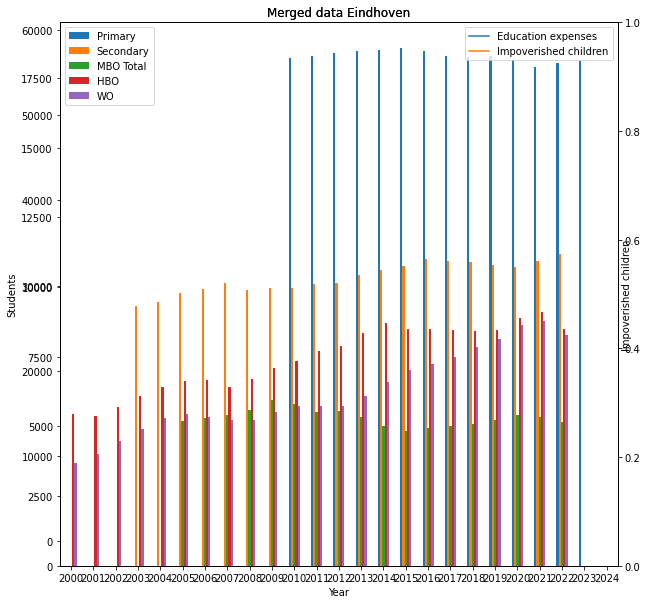

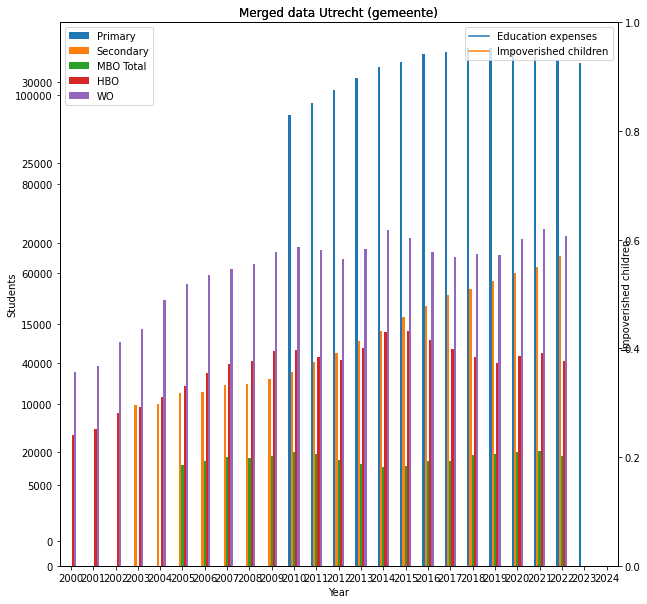

In [10]:
from merging import plot_merged_df


for plot in plot_merged_df(merged_df, cities=['Eindhoven', 'Utrecht (gemeente)']):
    pass